# Pressure of an Ideal Gas

In this simulation, we will model an ideal gas of helium atoms, each with a mass of 4.0 g/mol and radius 140 pm, in a cubic container of length $L$. The atoms are modeled as hard spheres that make elastic collisions with the walls of the container and with each other.

## Research Questions

1. If we measure the pressure by the gas on the walls of the container numerically, how does it compare it to the pressure calculated from the ideal gas law?

2. How does changing the number of atoms affect the pressure?

3. How does changing the temperature affect the pressure?


## Theoretical Background

According to kinetic theory, the pressure, volume, and temperature of the gas are related according to

$$PV = Nk_B T$$

where $N$ is the number of atoms in the gas, $k_B$ is the Boltzmann constant, and $T$ is the temperature of the gas in kelvins.

When an atom collides with the wall of the container (elastically), the perpendicular component of the velocity of ball reverses in direction, but is constant in magnitude, as shown below.

![](ball-wall-collision.png)

Thus,

$$\vec{v}_{f,\parallel} = \vec{v}_{i,\parallel}$$

and

$$\vec{v}_{f,\perp} = -\vec{v}_{i,\perp}$$

The change in momentum of the ball during the collision is

$$\Delta \vec{p} = \vec{p}_f - \vec{p}_i = -2\vec{p}_{i,perp}$$

If the collision occurs during a time interval $\Delta t$, then the force by the wall on the ball is

$$\vec{F}_{wall} = \frac{\Delta \vec{p}}{\Delta t} = \frac{-2\vec{p}_{i,perp}}{\Delta t}$$

By reciprocity, the force by the ball on the wall is

$$\vec{F}_{ball} = \frac{\Delta \vec{p}}{\Delta t} = \frac{2\vec{p}_{i,perp}}{\Delta t}$$

Let's assume that the time interval for the collision is the same as the time step. Then in a time step $\Delta t$, the total instantaneous pressure on all of the walls of the container is

$$P = \dfrac{\sum_i^{N_{coll}}|\vec{F}_{ball,i}|}{6A_{wall}}$$

where the sum is over all simultaneous collisions of atoms with walls of the container. (By *simultaneous* we mean "within the same time step.") Note that the area of a single wall is $A_{wall}=L^2$.

The instaneous pressure will vary. In some time steps, no collisions with the walls occur. To compare with theory, we should calculate the average pressure over many time steps, which is

$$\bar{P} = \dfrac{\sum_{i}^{N_{iter}}P_i}{N_{iter}}$$

where $N_{iter}$ is the number of iterations (i.e. time steps) used to calculate the average and $P_i$ is the instantaneous pressure at each time step.

## Computational Model

The simulation of the helium gas is below. The length of the box is $L=40R$ where $R$ is the radius of a helium atom. It uses a temperature of 300 K. Atoms have random positions and random directions of initial velocity, but all atoms start with the same speed, the rms speed for an ideal gas of this temperature. 

$$v_0 = v_{rms} = \sqrt{\frac{3k_BT}{m}}$$

Run the simulation. After each iteration, the instantaneous pressure on the walls of the container is calculated and stored in a list. Wait until the VPython simulation finishes before running the next cell.

The following variables will affect how long it takes to run the model:

```python
N = 100 #toal number of atoms
Nsteps = 1e4 #total number of time steps for the while loop
```

To simulate more particles for a longer time, we can increase the values of these variables.

## Assumptions

We assume:

1. constant temperature.

2. elastic collisions between atoms and walls and atoms with each other.

In [1]:
from vpython import *
import numpy as np
import random as rand
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
def check_collisions():
    """Determine all pairs of colliding spheres in the global particles[] list. 
        
    """
    collided_pairs = [] #a list of pairs of spheres that are overlapping
    
    for i in range(N):
        for j in range(i+1,N): #start at i+1 to avoid double counting and to avoid self-collision
            d = mag(particles[i].pos - particles[j].pos)
            if d < 2*R:
                collided_pairs.append([i,j])            
    
    return collided_pairs

In [3]:
def calc_collision(i,j):
    """Calculate new velocity, momentum, and position of pairs of colliding spheres in the global particles[] list. 

    Keyword arguments:
    i -- index of one colliding sphere
    j -- index of second colliding sphere

    """

    global particles
    
    r1 = particles[i].pos
    r2 = particles[j].pos
    v1 = particles[i].v
    v2 = particles[j].v
    p1 = m*v1
    p2 = m*v2
    v1i = v1
    v2i = v2
    
    #transform to reference frame of particle 1
    v2rel = v2 - v1
    r2rel = r2 - r1
    
    #find time when collision ocurred
    dx = dot(r2rel, hat(v2rel))
    dy = mag(cross(r2rel, hat(v2rel)))
    if (dy>2*R): return #avoids math domain error
    alpha = asin(dy/2/R)
    d = 2*R*cos(alpha) + dx
    deltat = d/mag(v2rel)
    
    #move particles backward in time to their locations at the collision
    particles[i].pos = particles[i].pos - particles[i].v*deltat
    particles[j].pos = particles[j].pos - particles[j].v*deltat
    
    #calculate new momenta using CM reference frame
    r1 = particles[i].pos
    r2 = particles[j].pos
    M = 2*m #total mass
    ptot = p1+p2 #total momentum
    vcm = ptot/M
    v1rel = v1 - vcm
    v2rel = v2 - vcm
    p1rel = m*v1rel
    p2rel = m*v2rel
    r = r2 - r1
    p1rel = p1rel - 2*dot(p1rel,hat(r))*hat(r)
    p2rel = p2rel - 2*dot(p2rel,hat(r))*hat(r)
    v1rel = p1rel/m
    v2rel = p2rel/m
    v1 = vcm + v1rel
    v2 = vcm + v2rel
    p1 = m*v1
    p2 = m*v2
    particles[i].v = v1
    particles[j].v = v2

    #move particles forward in time to their locations at the end of the time step
    particles[i].pos = particles[i].pos + particles[i].v*deltat
    particles[j].pos = particles[j].pos + particles[j].v*deltat
    


In [5]:
scene = canvas(title="N Particles in a Box")

#constants
m = 4.0/1000/6.02e23 #mass of atom in kg
R = 140e-12 #radius of atom in m
L = 40*R #length of box in m
thick = L/100 #thickness of box wall in m
k = 1.4e-23 #boltzmann constant
T = 300 #temp in K
s =  np.sqrt(2*3/2*k*T/m) #initial speed
N = 100 #number of atoms
Nsteps = 1e4 #number of time steps for the loop

#visual objects
Lwall = box(pos = vec(-L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Rwall = box(pos = vec(L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Bwall = box(pos = vec(0, -L/2, 0), size = vec(L, thick, L), color=color.white)
Twall = box(pos = vec(0, L/2, 0), size = vec(L, thick, L), color=color.white)
Zwall = box(pos = vec(0, 0, -L/2), size = vec(L, L, thick), color=color.white)

particles = [] #list of particles

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), rand.uniform(-1,1)))
    particle.p = m*particle.v

    particles.append(particle)

#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        particles[pair[1]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
    collided_pairs = check_collisions()

#time
t = 0
dt = R/s/10
tlist = []
tlist.append(t)

#histogram stuff
histograms = [] #a list of histograms after each time step
deltav = 100 # bin width for v histogram
nbins = int(6000/deltav) #number of bins
bin_edges = [int(i*deltav) for i in range(nbins)] #left side of bins

#store histogram
counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
histograms.append(counts)

#pressure stuff
pressures = [] #list of instantaneous pressure
avepressures = [] #list of average wall pressure
pressures.append(0)#initial pressure is 0 since no collisions at t=0
avepressures.append(0)#initial average pressure is 0 since no collisions at t=0

#evolution
scene.pause()

iterations = 0 #count of number of iterations of while loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization

    #update position of each particle
    for particle in particles:
        particle.pos = particle.pos + particle.v*dt
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    dpx = 0 #sum of abs(dp.x) for all particles due to collision with walls
    dpy = 0 #sum of abs(dp.y) for all particles due to collision with walls
    dpz = 0 #sum of abs(dp.z) for all particles due to collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.v.x = - abs(particle.v.x)
            particle.p = m*particle.v
            dpx = dpx + abs(2*particle.p.x)
        elif particle.pos.x < -L/2:
            particle.v.x = abs(particle.v.x)
            particle.p = m*particle.v
            dpx = dpx + abs(2*particle.p.x)

        if particle.pos.y > L/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
            dpy = dpy + abs(2*particle.p.y)
        elif particle.pos.y < -L/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v
            dpy = dpy + abs(2*particle.p.y)

        if particle.pos.z > L/2:
            particle.v.z = - abs(particle.v.z)
            particle.p = m*particle.v
            dpz = dpz + abs(2*particle.p.z)
        elif particle.pos.z < -L/2:
            particle.v.z = abs(particle.v.z)
            particle.p = m*particle.v
            dpz = dpz + abs(2*particle.p.z)
    
    t = t + dt
    tlist.append(t)
    iterations = iterations+1

    #calculate pressure on walls
    Fx = dpx/dt #instantaneous Fmag on side walls
    Fy = dpy/dt #instantaneous Fmag on top and bottom walls
    Fz = dpz/dt #instantaneous Fmag on front and back walls
    Ftot = Fx+Fy+Fz #total force on walls
    P = Ftot/L**2/6 #total average pressure
    pressures.append(P)
    Pave = (avepressures[-1]*(iterations-1) + P)/iterations
    avepressures.append(Pave)

    #store histogram
    counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
    histograms.append(counts)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Instantaneous Pressure

Plot the instantaneous pressure as a function of time.

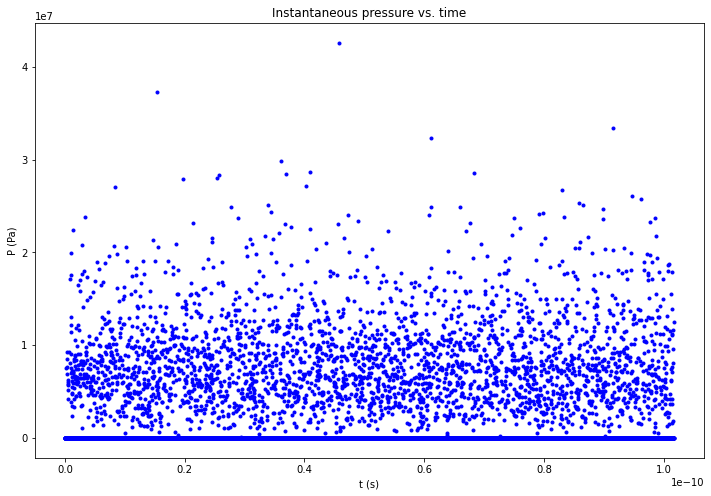

In [6]:
#plot instantaneous pressure
plt.figure(figsize=(12,8))
plt.title('Instantaneous pressure vs. time')
plt.plot(tlist,pressures,'b.')
plt.xlabel("t (s)")
plt.ylabel("P (Pa)")
plt.show()

The instantaneous pressure increases and decreases with each time step. The maximum is approximately $4\times 10^7$ Pa and the minimum is zero. In fact, there are so many time steps with zero pressure, the data points at $P=0$ look like a solid line.

## Average Pressure

The average pressure is the sum all the pressures divided by the total number of time steps. It was computed iteratively and stored in the list `avepressures`.

The theoretical pressure is calculated from the ideal gas law.

$$P_{theor} = \frac{Nk_BT}{V}$$

where $V$ is the volume of the container.

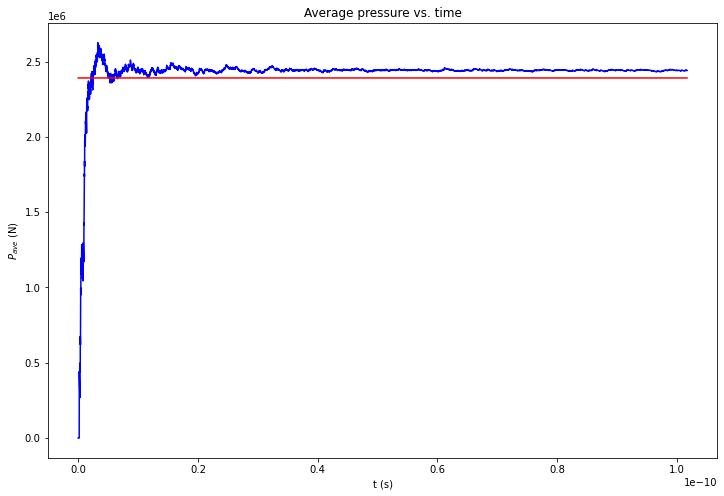

From ideal gas law: P = 2.39e+06 Pa
Average pressure in simulation: P = 2.44e+06 Pa
Percent difference = 2.12%


In [7]:
#Calculate theoretical pressure
V=L**3
Ptheor = N*k*T/V

#plot average pressure
plt.figure(figsize=(12,8))
plt.title('Average pressure vs. time')
plt.xlabel("t (s)")
plt.ylabel("$P_{ave}$ (Pa)")
plt.plot(tlist,avepressures,'b-', label='Mean Pressure')
plt.plot(tlist,np.ones(len(tlist))*Ptheor,'r-', label="Theory")
plt.show()

#print
print("From ideal gas law: P = {:.2e} Pa".format(Ptheor))

Pcalc=avepressures[-1]
print("Average pressure in simulation: P = {:.2e} Pa".format(Pcalc))

percentdiff = np.abs(Pcalc - Ptheor)/Ptheor*100
print("Percent difference = {:.2f}%".format(percentdiff))

The graph and calculations show that our calculation from the model is 2% different from the theoretical calculation using the ideal gas law.

# Change $N$

In the simulation below, we double the number of atoms to $N=200$. But first, store the average pressures from the previous simulation so we can graph it with the new average pressures for larger N.

In [8]:
Pave100 = avepressures.copy()

In [9]:
scene = canvas(title="N Particles in a Box")

#constants
m = 4.0/1000/6.02e23 #mass of atom in kg
R = 140e-12 #radius of atom in m
L = 40*R #length of box in m
thick = L/100 #thickness of box wall in m
k = 1.4e-23 #boltzmann constant
T = 300 #temp in K
s =  np.sqrt(2*3/2*k*T/m) #initial speed
N = 200 #number of atoms
Nsteps = 1e4 #number of time steps for the loop

#visual objects
Lwall = box(pos = vec(-L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Rwall = box(pos = vec(L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Bwall = box(pos = vec(0, -L/2, 0), size = vec(L, thick, L), color=color.white)
Twall = box(pos = vec(0, L/2, 0), size = vec(L, thick, L), color=color.white)
Zwall = box(pos = vec(0, 0, -L/2), size = vec(L, L, thick), color=color.white)

particles = [] #list of particles

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), rand.uniform(-1,1)))
    particle.p = m*particle.v

    particles.append(particle)

#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        particles[pair[1]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
    collided_pairs = check_collisions()

#time
t = 0
dt = R/s/10
tlist = []
tlist.append(t)

#histogram stuff
histograms = [] #a list of histograms after each time step
deltav = 100 # bin width for v histogram
nbins = int(6000/deltav) #number of bins
bin_edges = [int(i*deltav) for i in range(nbins)] #left side of bins

#store histogram
counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
histograms.append(counts)

#pressure stuff
pressures = [] #list of instantaneous pressure
avepressures = [] #list of average wall pressure
pressures.append(0)#initial pressure is 0 since no collisions at t=0
avepressures.append(0)#initial average pressure is 0 since no collisions at t=0

#evolution
scene.pause()

iterations = 0 #count of number of iterations of while loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization

    #update position of each particle
    for particle in particles:
        particle.pos = particle.pos + particle.v*dt
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    dpx = 0 #sum of abs(dp.x) for all particles due to collision with walls
    dpy = 0 #sum of abs(dp.y) for all particles due to collision with walls
    dpz = 0 #sum of abs(dp.z) for all particles due to collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.v.x = - abs(particle.v.x)
            particle.p = m*particle.v
            dpx = dpx + abs(2*particle.p.x)
        elif particle.pos.x < -L/2:
            particle.v.x = abs(particle.v.x)
            particle.p = m*particle.v
            dpx = dpx + abs(2*particle.p.x)

        if particle.pos.y > L/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
            dpy = dpy + abs(2*particle.p.y)
        elif particle.pos.y < -L/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v
            dpy = dpy + abs(2*particle.p.y)

        if particle.pos.z > L/2:
            particle.v.z = - abs(particle.v.z)
            particle.p = m*particle.v
            dpz = dpz + abs(2*particle.p.z)
        elif particle.pos.z < -L/2:
            particle.v.z = abs(particle.v.z)
            particle.p = m*particle.v
            dpz = dpz + abs(2*particle.p.z)
    
    t = t + dt
    tlist.append(t)
    iterations = iterations+1

    #calculate pressure on walls
    Fx = dpx/dt #instantaneous Fmag on side walls
    Fy = dpy/dt #instantaneous Fmag on top and bottom walls
    Fz = dpz/dt #instantaneous Fmag on front and back walls
    Ftot = Fx+Fy+Fz #total force on walls
    P = Ftot/L**2/6 #total average pressure
    pressures.append(P)
    Pave = (avepressures[-1]*(iterations-1) + P)/iterations
    avepressures.append(Pave)

    #store histogram
    counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
    histograms.append(counts)


<IPython.core.display.Javascript object>

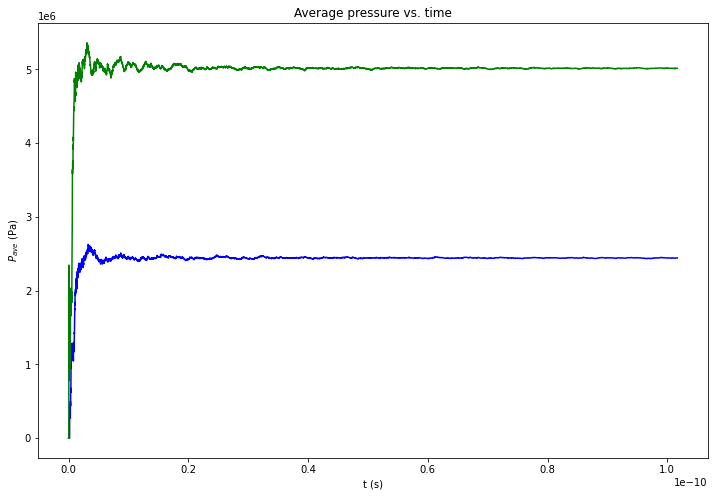

Average pressure for N=100: P = 2.44e+06 Pa
Average pressure for N=200: P = 5.01e+06 Pa
ratio of pressures: 2.05


In [11]:
#plot average pressure
plt.figure(figsize=(12,8))
plt.title('Average pressure vs. time')
plt.xlabel("t (s)")
plt.ylabel("$P_{ave}$ (Pa)")
plt.plot(tlist,Pave100,'b-', label='Mean Pressure (N=100)')
plt.plot(tlist,avepressures,'g-', label='Mean Pressure (N=200)')
plt.show()

#print
Pave1=Pave100[-1]
print("Average pressure for N=100: P = {:.2e} Pa".format(Pave1))
Pave2=avepressures[-1]
print("Average pressure for N=200: P = {:.2e} Pa".format(Pave2))
print("ratio of pressures: {:.2f}".format(Pave2/Pave1))


From the ideal gas law, if we double $N$, then we expect to double the pressure. In this case, it increased by 2.05 which is 2.5% higher than expected.

## Change Temperature

Increase the temperature of the gas from 300 K to 600 K. We expect to double the pressure. Let's see.

In [12]:
scene = canvas(title="N Particles in a Box")

#constants
m = 4.0/1000/6.02e23 #mass of atom in kg
R = 140e-12 #radius of atom in m
L = 40*R #length of box in m
thick = L/100 #thickness of box wall in m
k = 1.4e-23 #boltzmann constant
T = 600 #temp in K
s =  np.sqrt(2*3/2*k*T/m) #initial speed
N = 100 #number of atoms
Nsteps = 1e4 #number of time steps for the loop

#visual objects
Lwall = box(pos = vec(-L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Rwall = box(pos = vec(L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Bwall = box(pos = vec(0, -L/2, 0), size = vec(L, thick, L), color=color.white)
Twall = box(pos = vec(0, L/2, 0), size = vec(L, thick, L), color=color.white)
Zwall = box(pos = vec(0, 0, -L/2), size = vec(L, L, thick), color=color.white)

particles = [] #list of particles

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), rand.uniform(-1,1)))
    particle.p = m*particle.v

    particles.append(particle)

#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        particles[pair[1]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
    collided_pairs = check_collisions()

#time
t = 0
dt = R/s/10
tlist = []
tlist.append(t)

#histogram stuff
histograms = [] #a list of histograms after each time step
deltav = 100 # bin width for v histogram
nbins = int(6000/deltav) #number of bins
bin_edges = [int(i*deltav) for i in range(nbins)] #left side of bins

#store histogram
counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
histograms.append(counts)

#pressure stuff
pressures = [] #list of instantaneous pressure
avepressures = [] #list of average wall pressure
pressures.append(0)#initial pressure is 0 since no collisions at t=0
avepressures.append(0)#initial average pressure is 0 since no collisions at t=0

#evolution
scene.pause()

iterations = 0 #count of number of iterations of while loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization

    #update position of each particle
    for particle in particles:
        particle.pos = particle.pos + particle.v*dt
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    dpx = 0 #sum of abs(dp.x) for all particles due to collision with walls
    dpy = 0 #sum of abs(dp.y) for all particles due to collision with walls
    dpz = 0 #sum of abs(dp.z) for all particles due to collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.v.x = - abs(particle.v.x)
            particle.p = m*particle.v
            dpx = dpx + abs(2*particle.p.x)
        elif particle.pos.x < -L/2:
            particle.v.x = abs(particle.v.x)
            particle.p = m*particle.v
            dpx = dpx + abs(2*particle.p.x)

        if particle.pos.y > L/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
            dpy = dpy + abs(2*particle.p.y)
        elif particle.pos.y < -L/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v
            dpy = dpy + abs(2*particle.p.y)

        if particle.pos.z > L/2:
            particle.v.z = - abs(particle.v.z)
            particle.p = m*particle.v
            dpz = dpz + abs(2*particle.p.z)
        elif particle.pos.z < -L/2:
            particle.v.z = abs(particle.v.z)
            particle.p = m*particle.v
            dpz = dpz + abs(2*particle.p.z)
    
    t = t + dt
    tlist.append(t)
    iterations = iterations+1

    #calculate pressure on walls
    Fx = dpx/dt #instantaneous Fmag on side walls
    Fy = dpy/dt #instantaneous Fmag on top and bottom walls
    Fz = dpz/dt #instantaneous Fmag on front and back walls
    Ftot = Fx+Fy+Fz #total force on walls
    P = Ftot/L**2/6 #total average pressure
    pressures.append(P)
    Pave = (avepressures[-1]*(iterations-1) + P)/iterations
    avepressures.append(Pave)

    #store histogram
    counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
    histograms.append(counts)


<IPython.core.display.Javascript object>

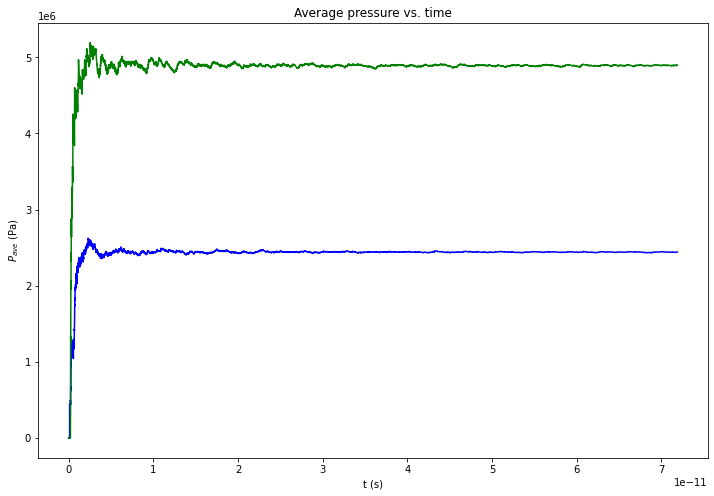

Average pressure for N=100, T=300 K: P = 2.44e+06 Pa
Average pressure for N=100, T=600 K: P = 4.90e+06 Pa
ratio of pressures: 2.005


In [16]:
#plot average pressure
plt.figure(figsize=(12,8))
plt.title('Average pressure vs. time')
plt.xlabel("t (s)")
plt.ylabel("$P_{ave}$ (Pa)")
plt.plot(tlist,Pave100[:-1],'b-', label='Mean Pressure (N=100, T=300 K)')
plt.plot(tlist,avepressures,'g-', label='Mean Pressure (N=100, T=600 K)')
plt.show()

#print
Pave1=Pave100[-1]
print("Average pressure for N=100, T=300 K: P = {:.2e} Pa".format(Pave1))
Pave2=avepressures[-1]
print("Average pressure for N=100, T=600 K: P = {:.2e} Pa".format(Pave2))
print("ratio of pressures: {:.3f}".format(Pave2/Pave1))


We expected the pressure to double, and it increased by a factor of 2.005.

## Conclusion

In this project, we simulated an ideal gas of helium atoms by assuming hard sphere elastic collisions. The measured pressure was within 2% of the calculated pressure using the ideal gas law, with $N=100$ atoms and a temperature of 300 K. We doubled $N$ and found the pressure increased by a factor 2.05, which was 2.5% higher than expected. We doubled the temperature and found that the pressure increaesd by 2.005, which is only 0.25% higher than expected.

In general, the results of our model agree with predictions of the ideal gas law.

In [ ]:
""